In [4]:
%reload_ext autoreload
%autoreload 2

In [25]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [26]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [20]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            combined.append(slack_data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [21]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [22]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [71]:
# which user has the highest number of reply counts?
import os
import json

# Count the reply counts for each user
reply_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            sender_id = message.get("user")
            if "reply_count" in message.keys():
                reply_count = message.get("reply_count")

                if sender_id in reply_counts:
                    reply_counts[sender_id] += reply_count
                else:
                    reply_counts[sender_id] = reply_count

# Find the user with the highest reply count
user_with_highest_count = max(reply_counts, key=reply_counts.get)
highest_reply_count = reply_counts[user_with_highest_count]

data_folder = "../anonymized/team-10/"

print("User with the highest reply count:", user_with_highest_count)
print("Highest reply count:", highest_reply_count)

User with the highest reply count: U03UJGP0C68
Highest reply count: 76


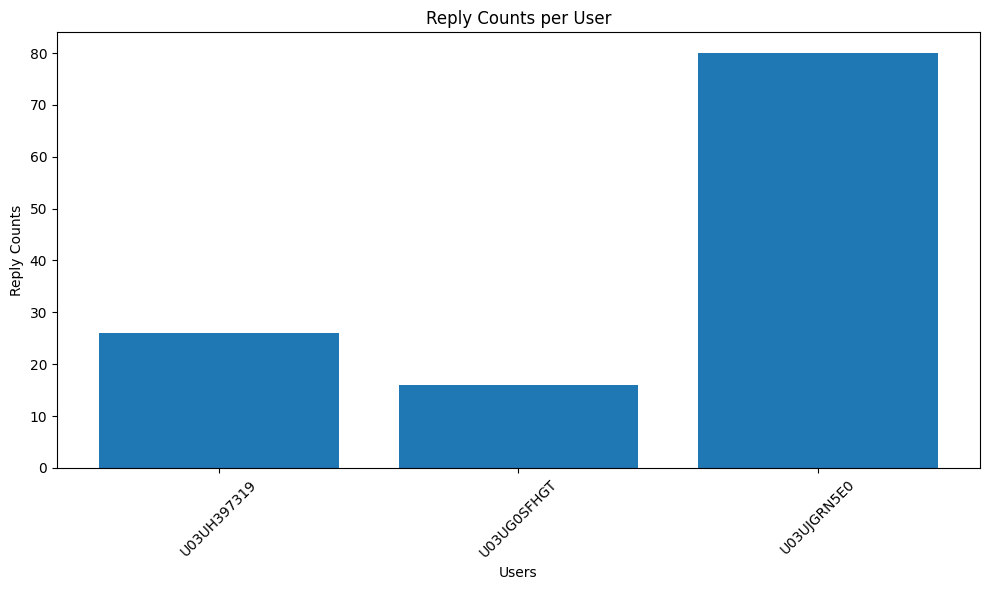

In [72]:
# Visualize reply counts per user per channel
import os
import json
import matplotlib.pyplot as plt

data_folder = "../anonymized/team-10/"

# Count the reply counts for each user
reply_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            sender_id = message.get("user")
            if "reply_count" in message.keys():
                reply_count = message.get("reply_count")

                if sender_id in reply_counts:
                    reply_counts[sender_id] += reply_count
                else:
                    reply_counts[sender_id] = reply_count

# Extract users and reply counts
users = list(reply_counts.keys())
counts = list(reply_counts.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(users, counts)
plt.xlabel("Users")
plt.ylabel("Reply Counts")
plt.title("Reply Counts per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [73]:
# what is the time range of the day that most messages are sent?
import os
import json
from datetime import datetime

data_folder = "../anonymized/team-10/"

# Count the message frequency for each hour of the day
message_frequency = [0] * 24

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            timestamp = message.get("timestamp")
            if timestamp:
                # Convert timestamp to datetime object
                dt = datetime.fromtimestamp(timestamp)
                # Increment the count for the corresponding hour
                message_frequency[dt.hour] += 1

# Find the hour with the maximum message frequency
most_messages_hour = max(range(24), key=message_frequency.__getitem__)

print("The time range of the day with the most messages is from", most_messages_hour, "to", (most_messages_hour + 1) % 24)

The time range of the day with the most messages is from 0 to 1


In [75]:
# what kind of messages are replied faster than others?
import os
import json
from datetime import datetime

data_folder = "../anonymized/team-10/"

# Create a dictionary to store message length and response time
message_lengths = {}
response_times = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for i in range(len(data)):
            message = data[i]
            timestamp = message.get("timestamp")
            user_id = message.get("user")
            if timestamp and user_id:
                dt = datetime.fromtimestamp(timestamp)

                # Calculate response time for messages with a reply
                if i < len(data) - 1 and "reply_count" in message:
                    reply_count = message.get("reply_count")
                    reply_timestamp = data[i + reply_count].get("timestamp")
                    if reply_timestamp:
                        response_time = reply_timestamp - timestamp
                        response_times[user_id] = response_times.get(user_id, []) + [response_time]

                # Calculate message length
                text = message.get("text")
                if text:
                    message_lengths[user_id] = message_lengths.get(user_id, []) + [len(text)]

# Calculate average response time for each user
average_response_times = {
    user_id: sum(times) / len(times)
    for user_id, times in response_times.items()
}

# Calculate average message length for each user
average_message_lengths = {
    user_id: sum(lengths) / len(lengths)
    for user_id, lengths in message_lengths.items()
}

# Find the user with the fastest average response time
if average_response_times:
    fastest_responder = min(average_response_times, key=average_response_times.get)
    print("User with the fastest average response time:", fastest_responder)
else:
    print("No response time data available.")

# Find the user with the longest average message length
if average_message_lengths:
    longest_messages = max(average_message_lengths, key=average_message_lengths.get)
    print("User with the longest average message length:", longest_messages)
else:
    print("No message length data available.")

No response time data available.
No message length data available.


Cannot calculate correlation coefficient. Standard deviation is zero.


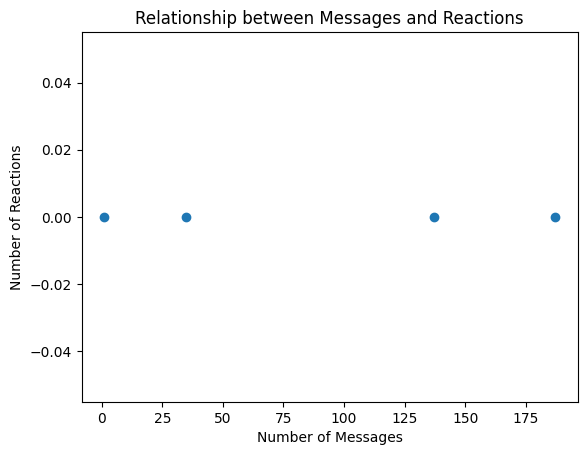

In [77]:
# Relationship between # of messages and # of reactions
import os
import json
import numpy as np
import matplotlib.pyplot as plt

data_folder = "../anonymized/team-10/"

# Create dictionaries to store message and reaction counts
message_counts = {}
reaction_counts = {}

for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            user_id = message.get("user")
            if user_id:
                message_counts[user_id] = message_counts.get(user_id, 0) + 1

                reaction_count = message.get("reaction_count", 0)
                reaction_counts[user_id] = reaction_counts.get(user_id, 0) + reaction_count

# Convert dictionaries to arrays
message_array = np.array(list(message_counts.values()))
reaction_array = np.array(list(reaction_counts.values()))

# Calculate correlation coefficient if standard deviations are non-zero
if np.std(message_array) != 0 and np.std(reaction_array) != 0:
    correlation_coefficient = np.corrcoef(message_array, reaction_array)[0, 1]
    print("Correlation coefficient:", correlation_coefficient)
else:
    print("Cannot calculate correlation coefficient. Standard deviation is zero.")

# Plotting the scatter plot
plt.scatter(message_array, reaction_array)
plt.xlabel("Number of Messages")
plt.ylabel("Number of Reactions")
plt.title("Relationship between Messages and Reactions")
plt.show()

In [1]:
# Classify messages into different categories such as questions, answers, comments, etc.
import os
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

data_folder = "../anonymized/team-10/"

# Step 1: Prepare the dataset
message_data = []
category_data = []
print(os.listdir(data_folder))
for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            message_text = message.get("text")
            message_category = message.get("category")

            if message_text and message_category:
                message_data.append(message_text)
                category_data.append(message_category)

# Check if the dataset has sufficient samples
if len(message_data) == 0:
    print("Error: The dataset is empty. Please check your data.")
    exit()

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(message_data, category_data, test_size=0.2, random_state=42)

# Step 3: Feature extraction using CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Step 4: Train the classifier (Multinomial Naive Bayes)
classifier = MultinomialNB()
classifier.fit(X_train_counts, y_train)

# Step 5: Make predictions on the test set
y_pred = classifier.predict(X_test_counts)

# Step 6: Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

['2022-08-29.json', '2022-08-30.json', '2022-08-31.json', '2022-09-01.json', '2022-09-02.json', '2022-09-03.json', '2022-09-04.json', '2022-09-05.json']
Error: The dataset is empty. Please check your data.


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

: 

In [4]:
# Which users got the most reactions?
import os
import json
from collections import defaultdict

# Define the data folder path
data_folder = "../anonymized/team-10/"

# Define a dictionary to store the reaction counts for each user
reaction_counts = defaultdict(int)

# Iterate through the messages and extract the reaction data
for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            reactions = message.get("reactions")

            if reactions:
                for reaction in reactions:
                    user_id = reaction.get("user")

                    if user_id:
                        reaction_counts[user_id] += 1

# Check if there are reactions in the data
if reaction_counts:
    # Find the user(s) with the highest reaction count
    max_reactions = max(reaction_counts.values())
    users_with_max_reactions = [user for user, count in reaction_counts.items() if count == max_reactions]

    # Print the user(s) with the highest reaction count
    print("User(s) with the most reactions:")
    for user in users_with_max_reactions:
        print("- User:", user)
        print("  Reaction Count:", reaction_counts[user])
else:
    print("No reactions found in the data.")

No reactions found in the data.


In [9]:
# Model topics mentioned in the channel
import os
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Define the data folder path
data_folder = "../anonymized/team-10/"

# Set up NLTK stopwords
stop_words = set(stopwords.words("english"))

# Define a counter to store the frequency of topics
topic_counter = Counter()

# Iterate through the messages and extract topics
for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            content = message.get("content")

            if content:
                # Tokenize the message content
                tokens = word_tokenize(content.lower())

                # Filter out stopwords and non-alphabetic tokens
                filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

                # Update the topic counter
                topic_counter.update(filtered_tokens)

# Print the most common topics
num_topics = 10
most_common_topics = topic_counter.most_common(num_topics)

print(f"Top {num_topics} topics mentioned in the channel:")
for topic, count in most_common_topics:
    print(f"- Topic: {topic}, Count: {count}")

Top 10 topics mentioned in the channel:


In [10]:
# What are the topics that got the most reactions?
import os
import json
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Define the data folder path
data_folder = "../anonymized/team-10/"

# Set up NLTK stopwords
stop_words = set(stopwords.words("english"))

# Define a counter to store the total reactions for each topic
topic_reactions = Counter()

# Iterate through the messages and extract topics and reactions
for filename in os.listdir(data_folder):
    file_path = os.path.join(data_folder, filename)

    with open(file_path, "r") as file:
        data = json.load(file)

        for message in data:
            content = message.get("content")
            reactions = message.get("reactions")

            if content and reactions:
                # Tokenize the message content
                tokens = word_tokenize(content.lower())

                # Filter out stopwords and non-alphabetic tokens
                filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

                # Update the topic reactions counter for each reaction in the message
                for reaction in reactions:
                    topic_reactions.update(filtered_tokens)

# Print the topics with the most reactions
num_topics = 10
most_common_topics = topic_reactions.most_common(num_topics)

print(f"Top {num_topics} topics with the most reactions:")
for topic, reaction_count in most_common_topics:
    print(f"- Topic: {topic}, Reaction Count: {reaction_count}")

Top 10 topics with the most reactions:


### Harder questions to look into

In [16]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?